## 将第一节课实践的DCGAN代码改成lsgan的损失函数

可以看下有提示的地方。

In [ ]:
#导入一些必要的包
import os
import random
import paddle 
import paddle.nn as nn
import paddle.optimizer as optim
import paddle.vision.datasets as dset
import paddle.vision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
dataset = paddle.vision.datasets.MNIST(mode='train', 
                                        transform=transforms.Compose([
                                        # resize ->(32,32)
                                        transforms.Resize((32,32)),
                                        # 归一化到-1~1
                                        transforms.Normalize([127.5], [127.5])
                                    ]))

dataloader = paddle.io.DataLoader(dataset, batch_size=256,
                                  shuffle=True, num_workers=4)

In [ ]:
#参数初始化的模块
@paddle.no_grad()
def normal_(x, mean=0., std=1.):
    temp_value = paddle.normal(mean, std, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def uniform_(x, a=-1., b=1.):
    temp_value = paddle.uniform(min=a, max=b, shape=x.shape)
    x.set_value(temp_value)
    return x

@paddle.no_grad()
def constant_(x, value):
    temp_value = paddle.full(x.shape, value, x.dtype)
    x.set_value(temp_value)
    return x

def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and classname.find('Conv') != -1:
        normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        normal_(m.weight, 1.0, 0.02)
        constant_(m.bias, 0)

## LSGAN

![](https://ai-studio-static-online.cdn.bcebos.com/1a77883e72a44fd88e265eff63e07a888dfe5c349ba44a629531d0a3bcbcbd4c)


In [16]:
# Generator Code
class Generator(nn.Layer):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input is Z, [B, 100, 1, 1] -> [B, 64 * 4, 4, 4]
            nn.Conv2DTranspose(100, 64 * 4, 4, 1, 0, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.ReLU(True),
            # state size. [B, 64 * 4, 4, 4] -> [B, 64 * 2, 8, 8]
            nn.Conv2DTranspose(64 * 4, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.ReLU(True),
            # state size. [B, 64 * 2, 8, 8] -> [B, 64, 16, 16]
            nn.Conv2DTranspose( 64 * 2, 64, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64),
            nn.ReLU(True),
            # state size. [B, 64, 16, 16] -> [B, 1, 32, 32]
            nn.Conv2DTranspose( 64, 1, 4, 2, 1, bias_attr=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


netG = Generator()
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): Conv2DTranspose(100, 256, kernel_size=[4, 4], data_format=NCHW)
    (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (2): ReLU(name=True)
    (3): Conv2DTranspose(256, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (4): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (5): ReLU(name=True)
    (6): Conv2DTranspose(128, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (7): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
    (8): ReLU(name=True)
    (9): Conv2DTranspose(64, 1, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (10): Tanh()
  )
)


In [17]:
class Discriminator(nn.Layer):
    def __init__(self,):
        super(Discriminator, self).__init__()
        self.dis = nn.Sequential(
            # input [B, 1, 32, 32] -> [B, 64, 16, 16]
            nn.Conv2D(1, 64, 4, 2, 1, bias_attr=False),
            nn.LeakyReLU(0.2),

            # state size. [B, 64, 16, 16] -> [B, 128, 8, 8]
            nn.Conv2D(64, 64 * 2, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 2),
            nn.LeakyReLU(0.2),

            # state size. [B, 128, 8, 8] -> [B, 256, 4, 4]
            nn.Conv2D(64 * 2, 64 * 4, 4, 2, 1, bias_attr=False),
            nn.BatchNorm2D(64 * 4),
            nn.LeakyReLU(0.2),

            # state size. [B, 256, 4, 4] -> [B, 1, 1, 1]
            nn.Conv2D(64 * 4, 1, 4, 1, 0, bias_attr=False),
            # 这里为需要改变的地方
            # nn.BatchNorm2D(256),
            # nn.LeakyReLU(0.2),
            # # state size. [B, 256, 1, 1] -> [B, 1]
            # nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.dis(x)

netD = Discriminator()
netD.apply(weights_init)
print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2D(1, 64, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2D(64, 128, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (3): BatchNorm2D(num_features=128, momentum=0.9, epsilon=1e-05)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2D(128, 256, kernel_size=[4, 4], stride=[2, 2], padding=1, data_format=NCHW)
    (6): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2D(256, 1, kernel_size=[4, 4], data_format=NCHW)
  )
)


In [18]:
# Initialize BCELoss function
# 这里为需要改变的地方
loss = nn.MSELoss(reduction='mean')

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = paddle.randn([32, 100, 1, 1], dtype='float32')

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(parameters=netD.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)
optimizerG = optim.Adam(parameters=netG.parameters(), learning_rate=0.0002, beta1=0.5, beta2=0.999)


![](https://ai-studio-static-online.cdn.bcebos.com/9d6f6621435041eeb9223d6298b714277c7257acc298420cbfaab49ce379fbfe)

Epoch ID=1 Batch ID=0 

 D-Loss=1.9358999729156494 G-Loss=0.4397525489330292


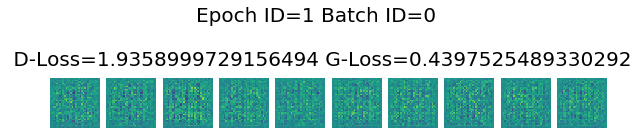

Epoch ID=1 Batch ID=200 

 D-Loss=0.14011457562446594 G-Loss=0.5309092402458191


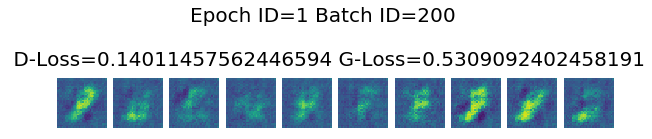

Epoch ID=2 Batch ID=0 

 D-Loss=0.08318828791379929 G-Loss=0.5768296122550964


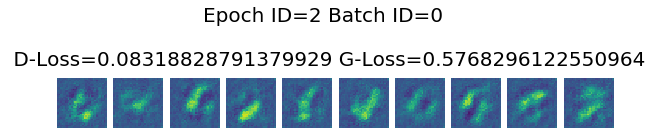

Epoch ID=2 Batch ID=200 

 D-Loss=0.05095591023564339 G-Loss=0.2649965286254883


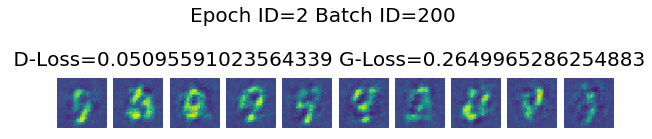

Epoch ID=3 Batch ID=0 

 D-Loss=0.056007519364356995 G-Loss=0.5535615682601929


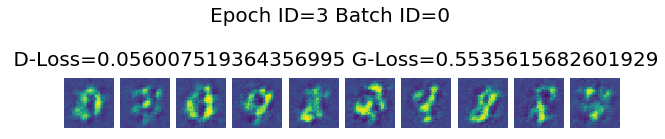

Epoch ID=3 Batch ID=200 

 D-Loss=0.16651543974876404 G-Loss=0.2760796546936035


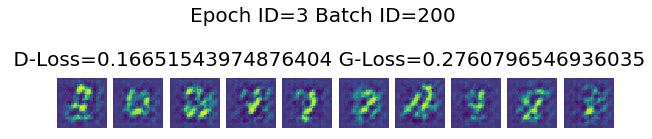

Epoch ID=4 Batch ID=0 

 D-Loss=0.10240086913108826 G-Loss=0.3066198229789734


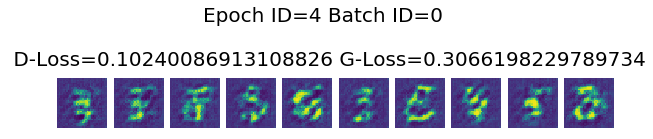

Epoch ID=4 Batch ID=200 

 D-Loss=0.04027729481458664 G-Loss=0.46226999163627625


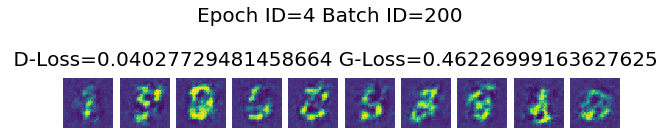

Epoch ID=5 Batch ID=0 

 D-Loss=0.04875844717025757 G-Loss=0.4858550429344177


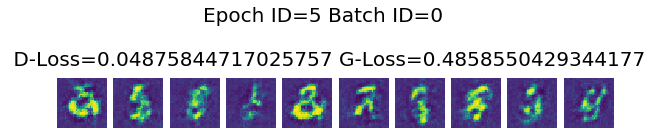

Epoch ID=5 Batch ID=200 

 D-Loss=0.06634216010570526 G-Loss=0.37016624212265015


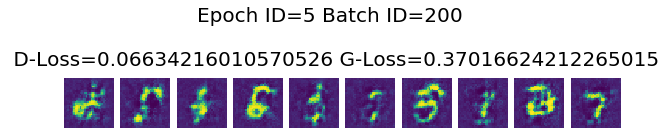

Epoch ID=6 Batch ID=0 

 D-Loss=0.07013087719678879 G-Loss=0.5703140497207642


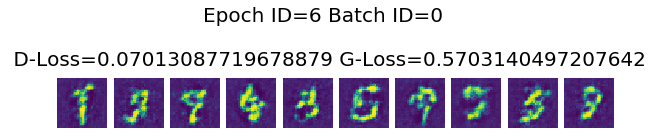

Epoch ID=6 Batch ID=200 

 D-Loss=0.04941677302122116 G-Loss=0.4298223853111267


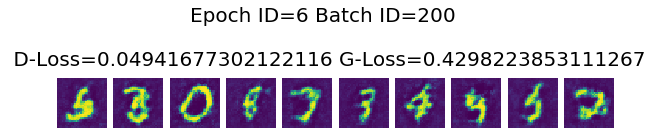

Epoch ID=7 Batch ID=0 

 D-Loss=0.0657932236790657 G-Loss=0.6177952289581299


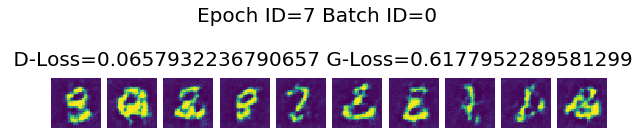

Epoch ID=7 Batch ID=200 

 D-Loss=0.12208119034767151 G-Loss=0.25224268436431885


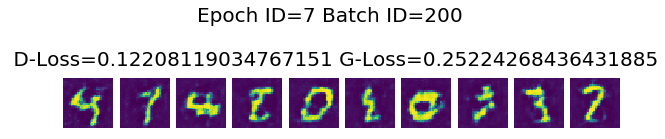

Epoch ID=8 Batch ID=0 

 D-Loss=0.05166909843683243 G-Loss=0.3641071617603302


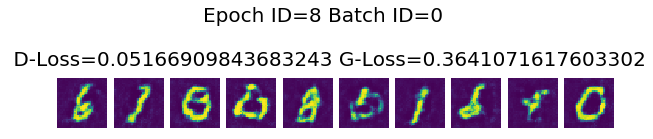

Epoch ID=8 Batch ID=200 

 D-Loss=0.06245502829551697 G-Loss=0.35313963890075684


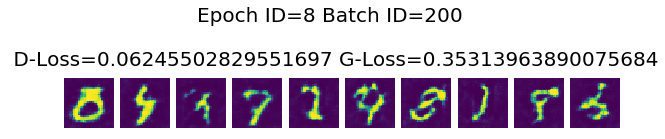

Epoch ID=9 Batch ID=0 

 D-Loss=0.06263755261898041 G-Loss=0.48434412479400635


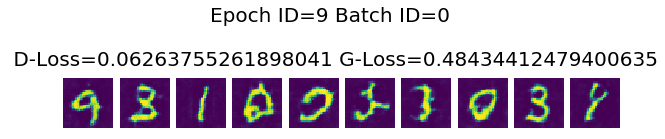

Epoch ID=9 Batch ID=200 

 D-Loss=0.09722050279378891 G-Loss=0.30322062969207764


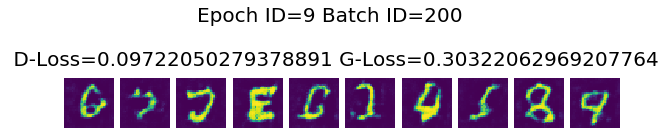

Epoch ID=10 Batch ID=0 

 D-Loss=0.07305487245321274 G-Loss=0.3304668664932251


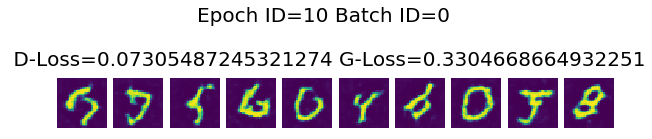

Epoch ID=10 Batch ID=200 

 D-Loss=0.08700525015592575 G-Loss=0.32991454005241394


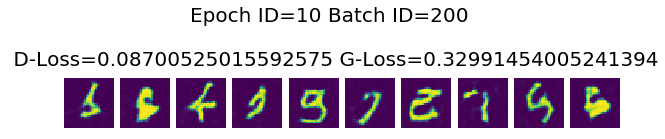

Epoch ID=11 Batch ID=0 

 D-Loss=0.16245760023593903 G-Loss=0.07061893492937088


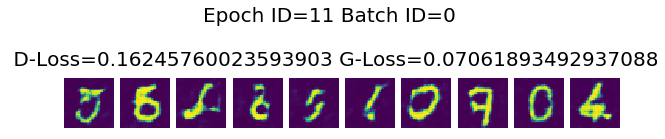

Epoch ID=11 Batch ID=200 

 D-Loss=0.0819011852145195 G-Loss=0.342020183801651


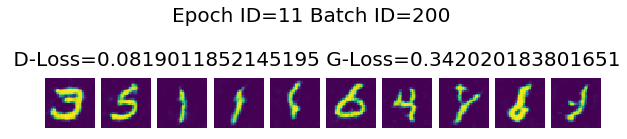

Epoch ID=12 Batch ID=0 

 D-Loss=0.11193335801362991 G-Loss=0.4040062427520752


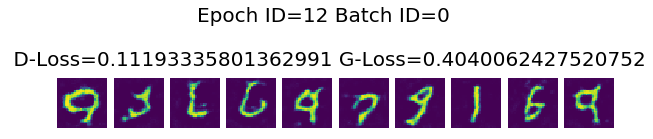

Epoch ID=12 Batch ID=200 

 D-Loss=0.14146685600280762 G-Loss=0.22948504984378815


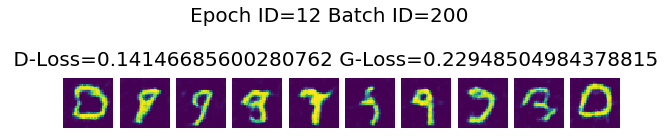

Epoch ID=13 Batch ID=0 

 D-Loss=0.1407606303691864 G-Loss=0.21904397010803223


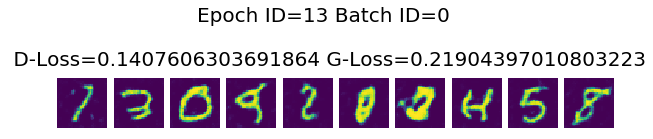

Epoch ID=13 Batch ID=200 

 D-Loss=0.14384600520133972 G-Loss=0.20803123712539673


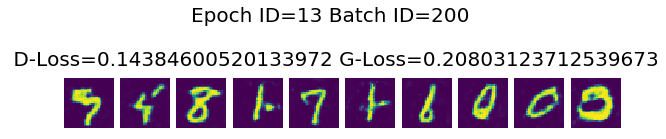

Epoch ID=14 Batch ID=0 

 D-Loss=0.1410936713218689 G-Loss=0.3481510281562805


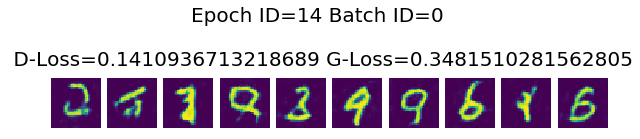

Epoch ID=14 Batch ID=200 

 D-Loss=0.09363558888435364 G-Loss=0.40402790904045105


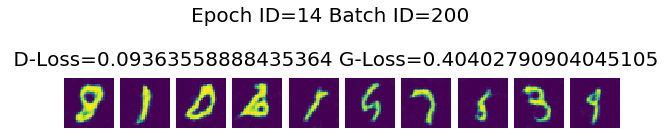

Epoch ID=15 Batch ID=0 

 D-Loss=0.13204115629196167 G-Loss=0.20727597177028656


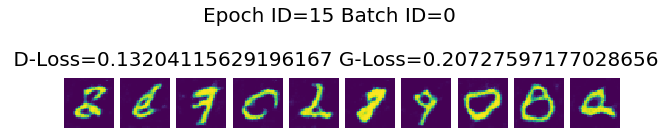

Epoch ID=15 Batch ID=200 

 D-Loss=0.1333109736442566 G-Loss=0.40094128251075745


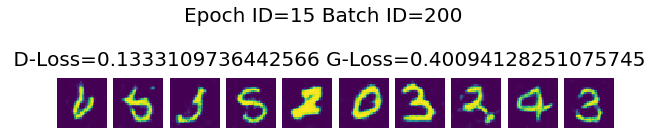

Epoch ID=16 Batch ID=0 

 D-Loss=0.07008375227451324 G-Loss=0.23720017075538635


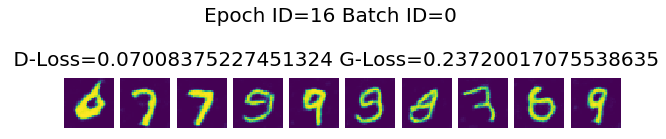

Epoch ID=16 Batch ID=200 

 D-Loss=0.06598413735628128 G-Loss=0.3849075436592102


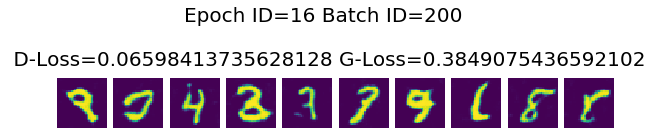

Epoch ID=17 Batch ID=0 

 D-Loss=0.12807004153728485 G-Loss=0.5222793817520142


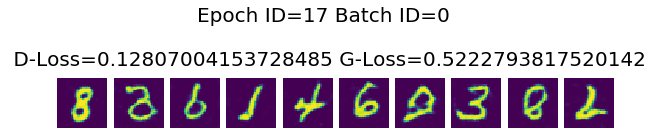

Epoch ID=17 Batch ID=200 

 D-Loss=0.11763454973697662 G-Loss=0.31442397832870483


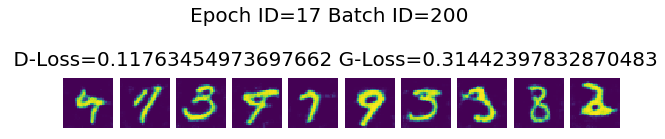

Epoch ID=18 Batch ID=0 

 D-Loss=0.09341304749250412 G-Loss=0.28636062145233154


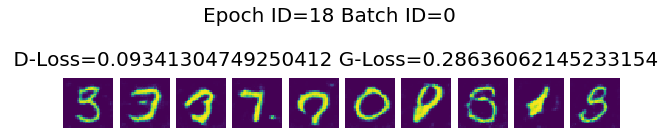

Epoch ID=18 Batch ID=200 

 D-Loss=0.1240253895521164 G-Loss=0.478136271238327


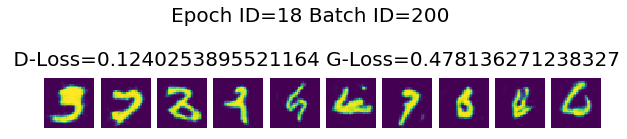

Epoch ID=19 Batch ID=0 

 D-Loss=0.10306382179260254 G-Loss=0.32745546102523804


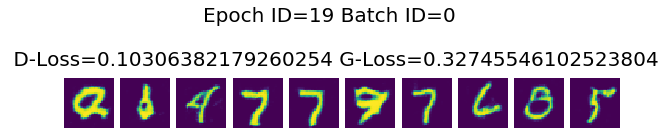

Epoch ID=19 Batch ID=200 

 D-Loss=0.09123299270868301 G-Loss=0.275331974029541


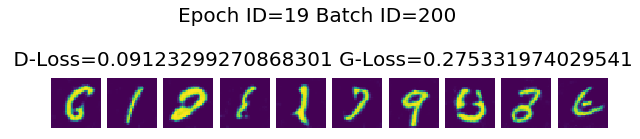

Epoch ID=20 Batch ID=0 

 D-Loss=0.08526082336902618 G-Loss=0.3030626177787781


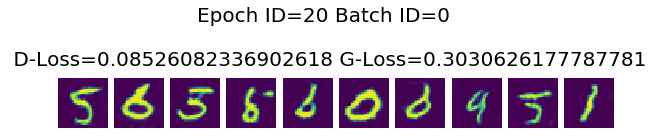

Epoch ID=20 Batch ID=200 

 D-Loss=0.08270453661680222 G-Loss=0.3835517466068268


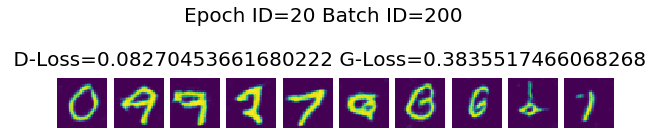

Epoch ID=21 Batch ID=0 

 D-Loss=0.24839378893375397 G-Loss=0.03984356299042702


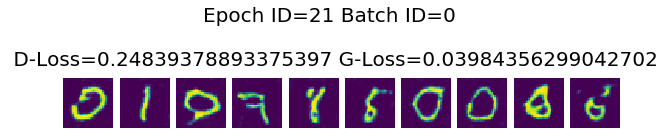

Epoch ID=21 Batch ID=200 

 D-Loss=0.12763184309005737 G-Loss=0.3032982349395752


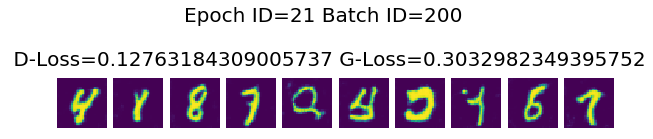

Epoch ID=22 Batch ID=0 

 D-Loss=0.08393190056085587 G-Loss=0.46028125286102295


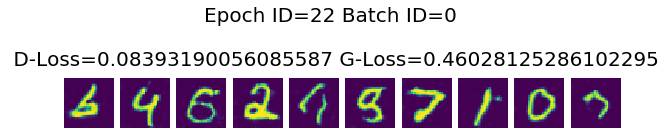

Epoch ID=22 Batch ID=200 

 D-Loss=0.18204379081726074 G-Loss=0.7845019102096558


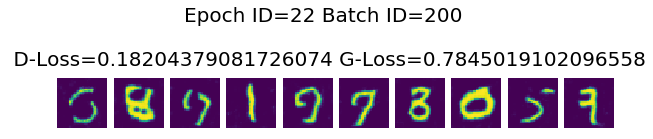

Epoch ID=23 Batch ID=0 

 D-Loss=0.08186294883489609 G-Loss=0.22363737225532532


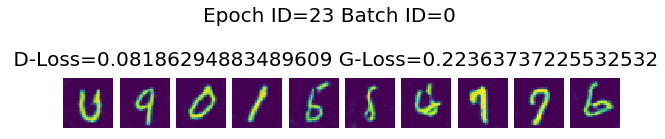

Epoch ID=23 Batch ID=200 

 D-Loss=0.0676991268992424 G-Loss=0.29139235615730286


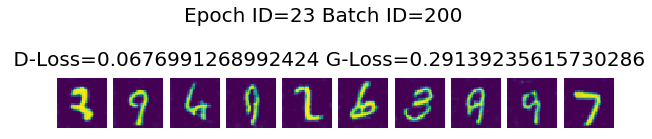

Epoch ID=24 Batch ID=0 

 D-Loss=0.07445225119590759 G-Loss=0.24321064352989197


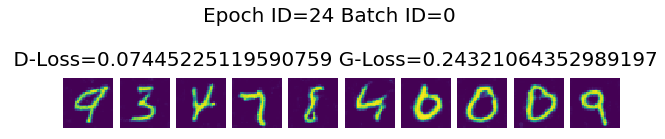

Epoch ID=24 Batch ID=200 

 D-Loss=0.08614002913236618 G-Loss=0.5474581122398376


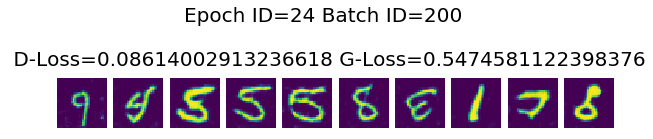

Epoch ID=25 Batch ID=0 

 D-Loss=0.1299048811197281 G-Loss=0.6094257831573486


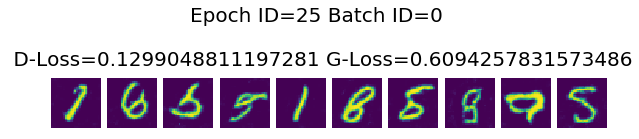

Epoch ID=25 Batch ID=200 

 D-Loss=0.06896286457777023 G-Loss=0.3311704993247986


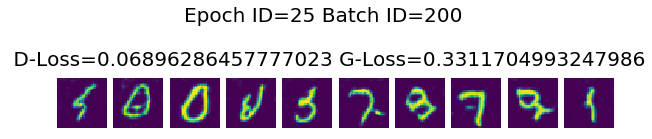

Epoch ID=26 Batch ID=0 

 D-Loss=0.04075194150209427 G-Loss=0.42883554100990295


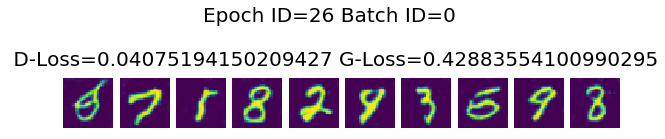

Epoch ID=26 Batch ID=200 

 D-Loss=0.03546310216188431 G-Loss=0.5567054748535156


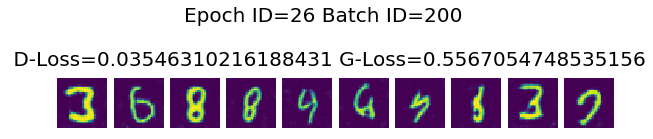

Epoch ID=27 Batch ID=0 

 D-Loss=0.03217652067542076 G-Loss=0.5413481593132019


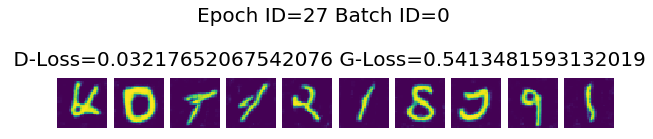

Epoch ID=27 Batch ID=200 

 D-Loss=0.14083488285541534 G-Loss=0.5360519289970398


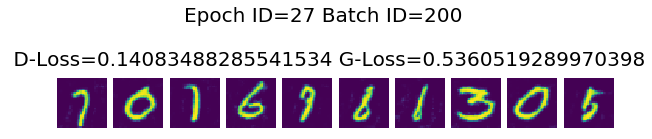

Epoch ID=28 Batch ID=0 

 D-Loss=0.23782791197299957 G-Loss=0.5572793483734131


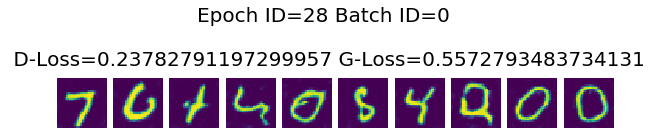

Epoch ID=28 Batch ID=200 

 D-Loss=0.032802361994981766 G-Loss=0.5766098499298096


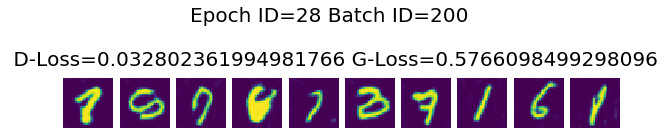

Epoch ID=29 Batch ID=0 

 D-Loss=0.04188483953475952 G-Loss=0.4513552784919739


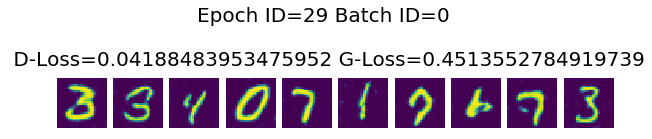

Epoch ID=29 Batch ID=200 

 D-Loss=0.018980396911501884 G-Loss=0.5372178554534912


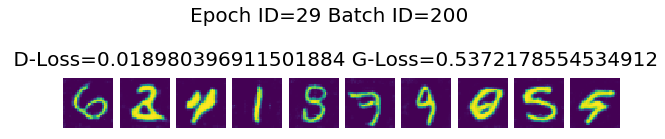

Epoch ID=30 Batch ID=0 

 D-Loss=0.033416472375392914 G-Loss=0.5616002678871155


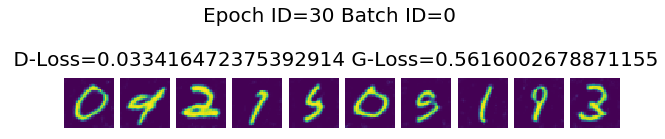

Epoch ID=30 Batch ID=200 

 D-Loss=0.034037716686725616 G-Loss=0.45366817712783813


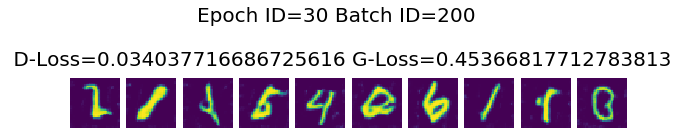

Epoch ID=31 Batch ID=0 

 D-Loss=0.06616193801164627 G-Loss=0.6179721355438232


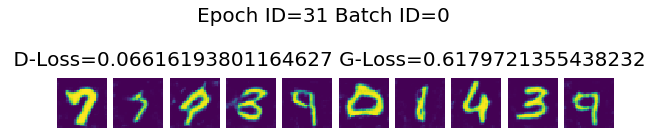

Epoch ID=31 Batch ID=200 

 D-Loss=0.018991095945239067 G-Loss=0.38347187638282776


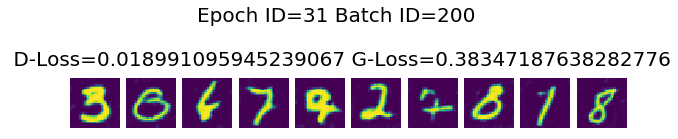

Epoch ID=32 Batch ID=0 

 D-Loss=0.03590890392661095 G-Loss=0.4349137842655182


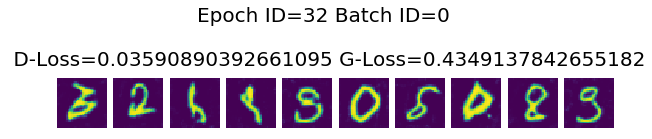

Epoch ID=32 Batch ID=200 

 D-Loss=0.018221667036414146 G-Loss=0.45934271812438965


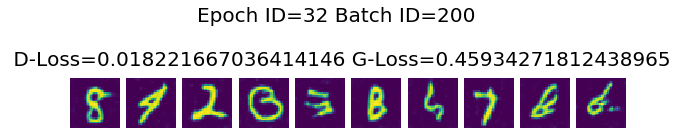

Epoch ID=33 Batch ID=0 

 D-Loss=0.03594384714961052 G-Loss=0.6656414866447449


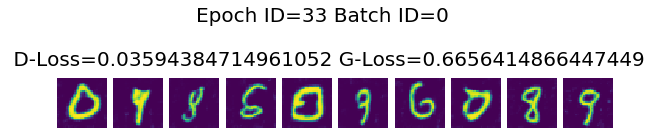

Epoch ID=33 Batch ID=200 

 D-Loss=0.023090824484825134 G-Loss=0.5072858929634094


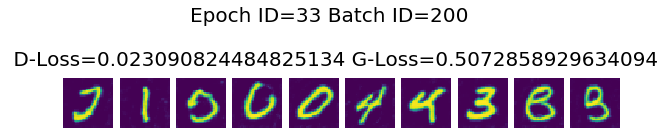

Epoch ID=34 Batch ID=0 

 D-Loss=0.027561450377106667 G-Loss=0.5276408195495605


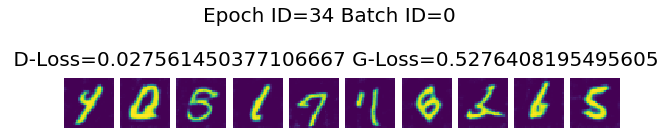

Epoch ID=34 Batch ID=200 

 D-Loss=0.014042315073311329 G-Loss=0.45030951499938965


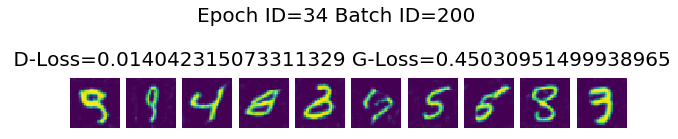

Epoch ID=35 Batch ID=0 

 D-Loss=0.53480064868927 G-Loss=0.4174194037914276


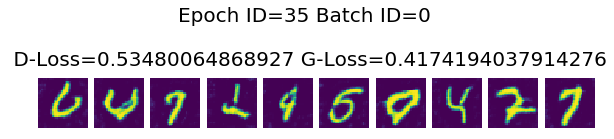

Epoch ID=35 Batch ID=200 

 D-Loss=0.02156827598810196 G-Loss=0.5660157203674316


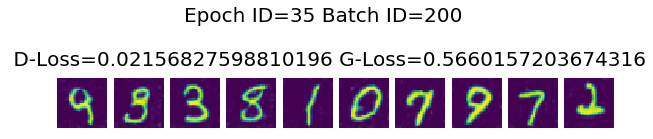

Epoch ID=36 Batch ID=0 

 D-Loss=0.05239243805408478 G-Loss=0.35601192712783813


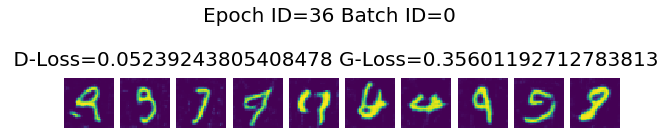

Epoch ID=36 Batch ID=200 

 D-Loss=0.1254400610923767 G-Loss=0.18204446136951447


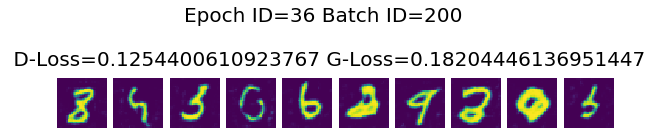

Epoch ID=37 Batch ID=0 

 D-Loss=0.03092839941382408 G-Loss=0.553573727607727


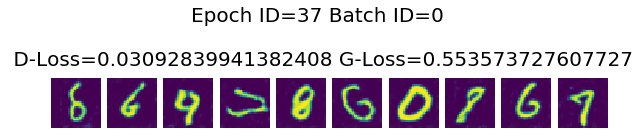

Epoch ID=37 Batch ID=200 

 D-Loss=0.04508724808692932 G-Loss=0.3541739583015442


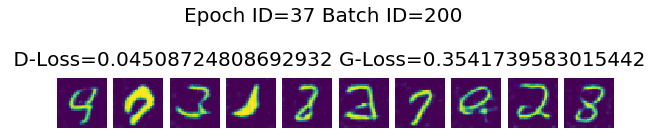

Epoch ID=38 Batch ID=0 

 D-Loss=0.01759999990463257 G-Loss=0.39668557047843933


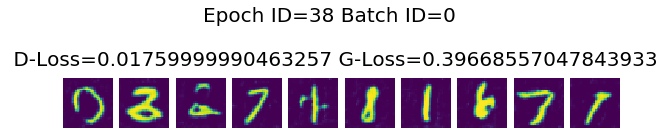

Epoch ID=38 Batch ID=200 

 D-Loss=0.01126034278422594 G-Loss=0.5406288504600525


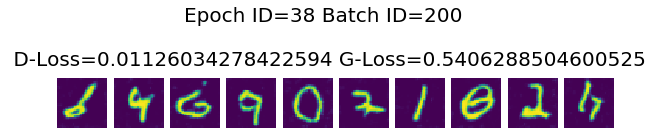

Epoch ID=39 Batch ID=0 

 D-Loss=0.14202409982681274 G-Loss=0.24805854260921478


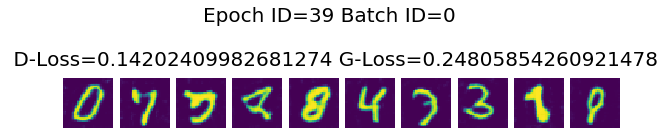

Epoch ID=39 Batch ID=200 

 D-Loss=0.051506996154785156 G-Loss=0.4415804445743561


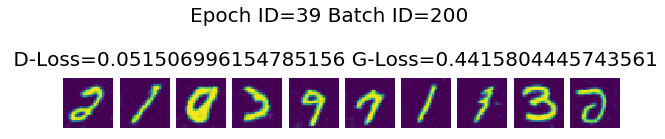

Epoch ID=40 Batch ID=0 

 D-Loss=0.02312622405588627 G-Loss=0.40217265486717224


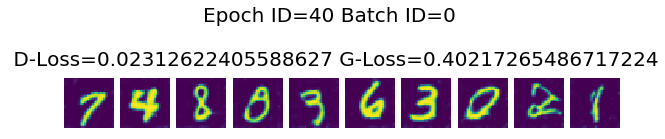

Epoch ID=40 Batch ID=200 

 D-Loss=0.12150440365076065 G-Loss=0.358845591545105


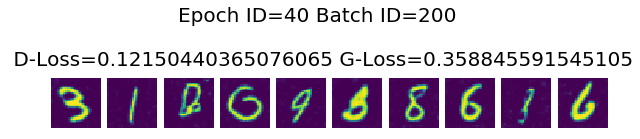

Epoch ID=41 Batch ID=0 

 D-Loss=0.012109722942113876 G-Loss=0.4883597493171692


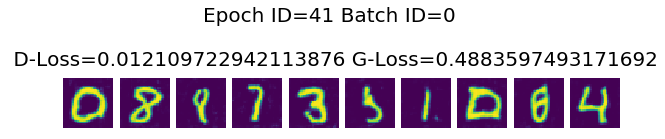

Epoch ID=41 Batch ID=200 

 D-Loss=0.01236964762210846 G-Loss=0.45272180438041687


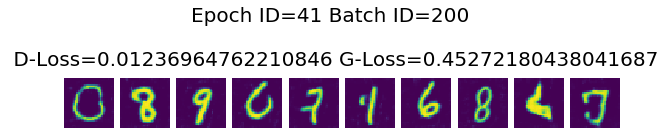

Epoch ID=42 Batch ID=0 

 D-Loss=0.03434368968009949 G-Loss=0.38126999139785767


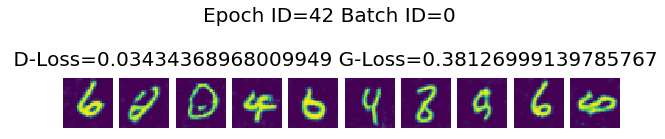

Epoch ID=42 Batch ID=200 

 D-Loss=0.028646770864725113 G-Loss=0.4319068491458893


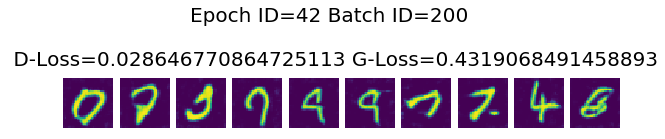

Epoch ID=43 Batch ID=0 

 D-Loss=0.040046561509370804 G-Loss=0.30067142844200134


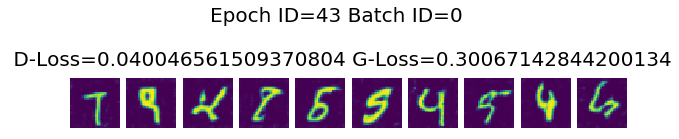

Epoch ID=43 Batch ID=200 

 D-Loss=0.014283208176493645 G-Loss=0.4916715621948242


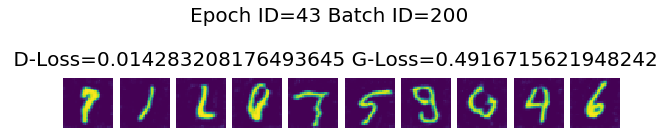

Epoch ID=44 Batch ID=0 

 D-Loss=0.043321214616298676 G-Loss=0.5637978315353394


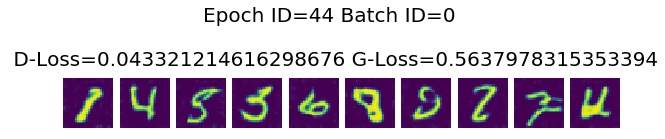

Epoch ID=44 Batch ID=200 

 D-Loss=0.01891147717833519 G-Loss=0.42210039496421814


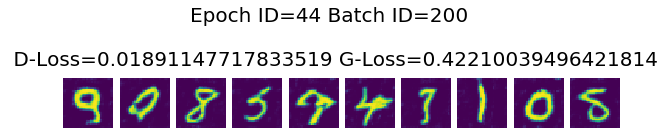

Epoch ID=45 Batch ID=0 

 D-Loss=0.033087506890296936 G-Loss=0.3949100375175476


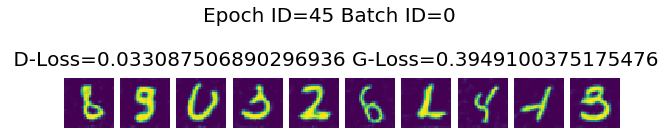

Epoch ID=45 Batch ID=200 

 D-Loss=0.017312362790107727 G-Loss=0.532122015953064


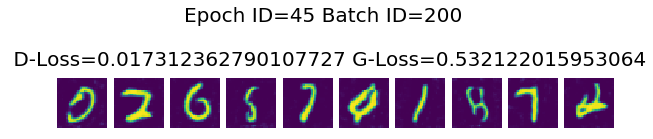

Epoch ID=46 Batch ID=0 

 D-Loss=0.03380369767546654 G-Loss=0.44601812958717346


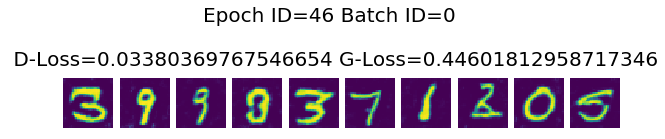

Epoch ID=46 Batch ID=200 

 D-Loss=0.14455175399780273 G-Loss=0.26798319816589355


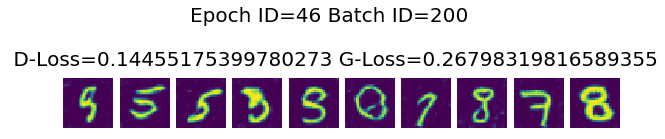

Epoch ID=47 Batch ID=0 

 D-Loss=0.03448718041181564 G-Loss=0.43428459763526917


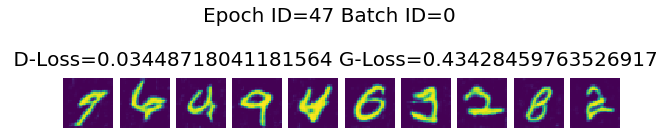

Epoch ID=47 Batch ID=200 

 D-Loss=0.020372087135910988 G-Loss=0.38851702213287354


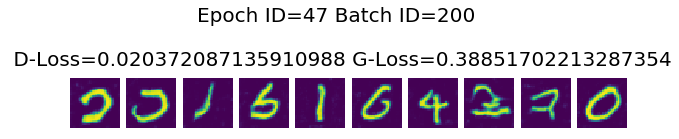

Epoch ID=48 Batch ID=0 

 D-Loss=0.034692615270614624 G-Loss=0.3830767869949341


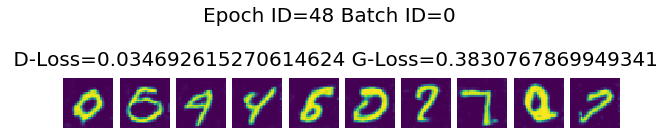

Epoch ID=48 Batch ID=200 

 D-Loss=0.013386985287070274 G-Loss=0.49480679631233215


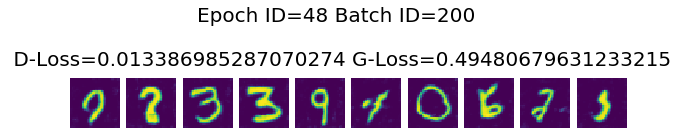

Epoch ID=49 Batch ID=0 

 D-Loss=0.03152847662568092 G-Loss=0.39540737867355347


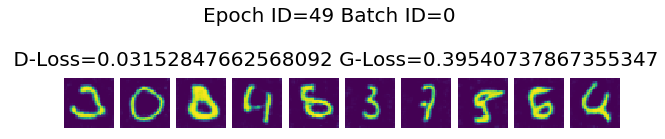

Epoch ID=49 Batch ID=200 

 D-Loss=0.04604679346084595 G-Loss=0.4395075738430023


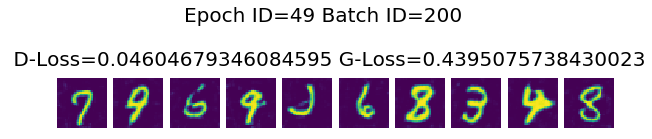

Epoch ID=50 Batch ID=0 

 D-Loss=0.010768365114927292 G-Loss=0.4710789620876312


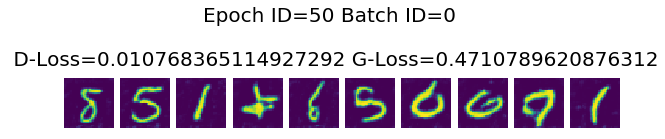

Epoch ID=50 Batch ID=200 

 D-Loss=0.04687187820672989 G-Loss=0.5388808250427246


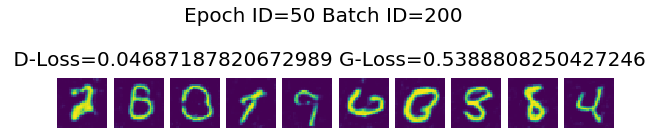

Epoch ID=51 Batch ID=0 

 D-Loss=0.01640937104821205 G-Loss=0.4570675790309906


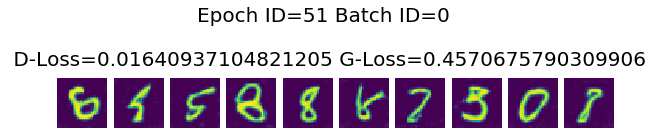

Epoch ID=51 Batch ID=200 

 D-Loss=0.007521261926740408 G-Loss=0.5127817392349243


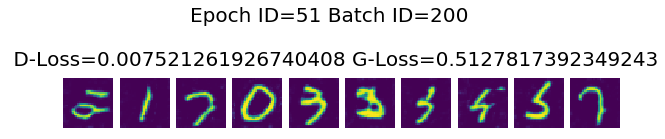

Epoch ID=52 Batch ID=0 

 D-Loss=0.009638838469982147 G-Loss=0.5628988146781921


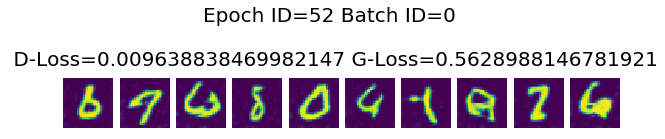

Epoch ID=52 Batch ID=200 

 D-Loss=0.1559613049030304 G-Loss=0.22937297821044922


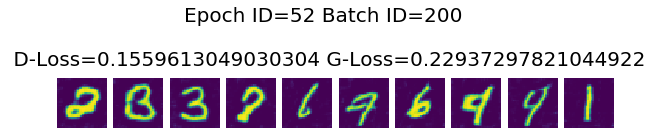

Epoch ID=53 Batch ID=0 

 D-Loss=0.010718435049057007 G-Loss=0.46601757407188416


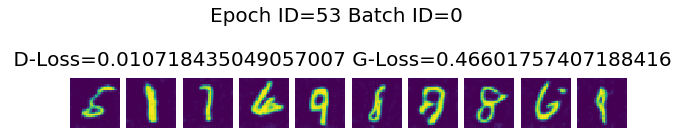

Epoch ID=53 Batch ID=200 

 D-Loss=0.01701526716351509 G-Loss=0.5642077326774597


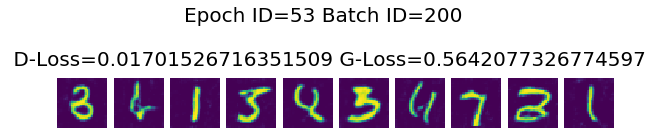

Epoch ID=54 Batch ID=0 

 D-Loss=0.013741908594965935 G-Loss=0.5463123917579651


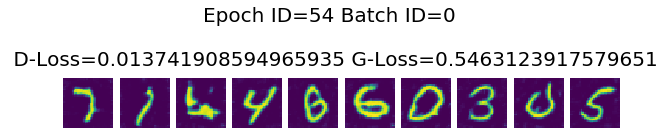

Epoch ID=54 Batch ID=200 

 D-Loss=0.2041378617286682 G-Loss=0.913519561290741


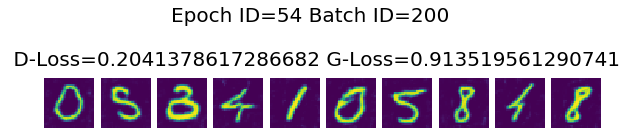

Epoch ID=55 Batch ID=0 

 D-Loss=0.014377165585756302 G-Loss=0.4521406590938568


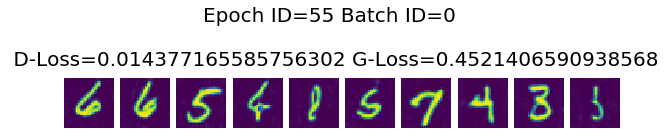

Epoch ID=55 Batch ID=200 

 D-Loss=0.01921449974179268 G-Loss=0.647456169128418


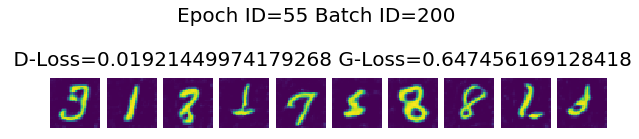

Epoch ID=56 Batch ID=0 

 D-Loss=0.014359314925968647 G-Loss=0.4439166188240051


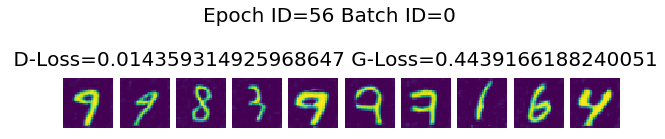

Epoch ID=56 Batch ID=200 

 D-Loss=0.03800737112760544 G-Loss=0.482934832572937


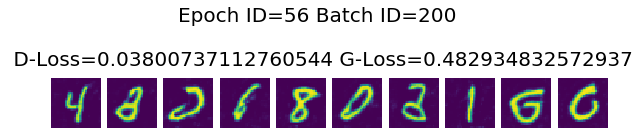

Epoch ID=57 Batch ID=0 

 D-Loss=0.022446375340223312 G-Loss=0.3803800046443939


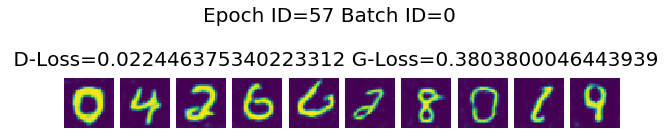

Epoch ID=57 Batch ID=200 

 D-Loss=0.010543134063482285 G-Loss=0.4504256844520569


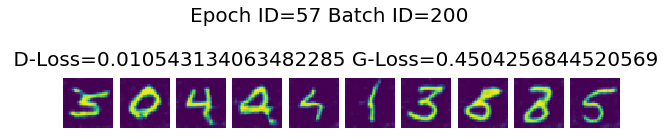

Epoch ID=58 Batch ID=0 

 D-Loss=0.009165606461465359 G-Loss=0.5118986368179321


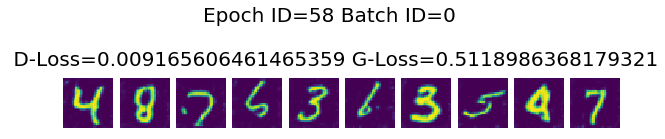

Epoch ID=58 Batch ID=200 

 D-Loss=0.2139129340648651 G-Loss=0.08673737198114395


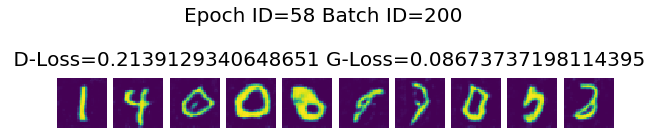

Epoch ID=59 Batch ID=0 

 D-Loss=0.026426944881677628 G-Loss=0.3183555006980896


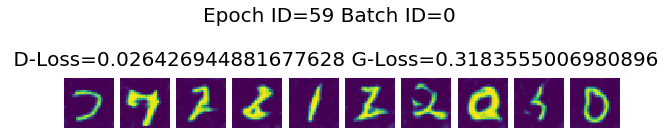

Epoch ID=59 Batch ID=200 

 D-Loss=0.010853467509150505 G-Loss=0.506156325340271


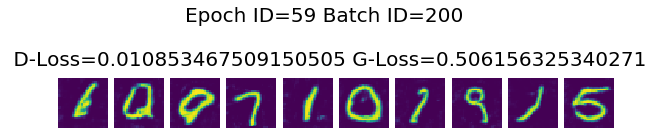

Epoch ID=60 Batch ID=0 

 D-Loss=0.012076104059815407 G-Loss=0.544084906578064


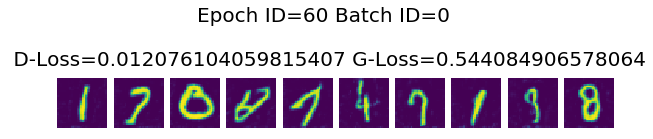

Epoch ID=60 Batch ID=200 

 D-Loss=0.009974794462323189 G-Loss=0.5117498636245728


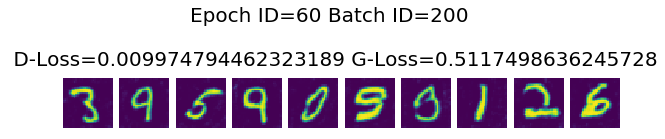

Epoch ID=61 Batch ID=0 

 D-Loss=0.016369672492146492 G-Loss=0.3860127925872803


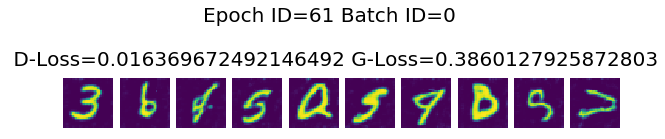

Epoch ID=61 Batch ID=200 

 D-Loss=0.01673722267150879 G-Loss=0.38732659816741943


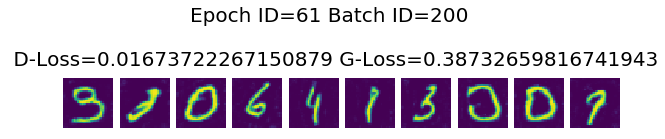

Epoch ID=62 Batch ID=0 

 D-Loss=0.017186854034662247 G-Loss=0.4323083162307739


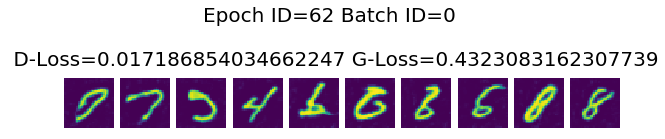

Epoch ID=62 Batch ID=200 

 D-Loss=0.11228826642036438 G-Loss=0.2907510995864868


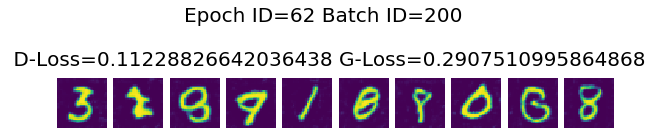

Epoch ID=63 Batch ID=0 

 D-Loss=0.060189388692379 G-Loss=0.790605902671814


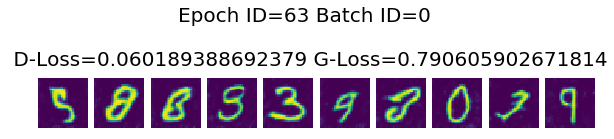

Epoch ID=63 Batch ID=200 

 D-Loss=0.036751143634319305 G-Loss=0.4436638653278351


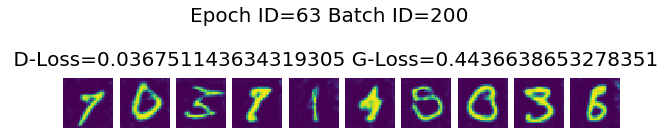

Epoch ID=64 Batch ID=0 

 D-Loss=0.008931487798690796 G-Loss=0.5022826790809631


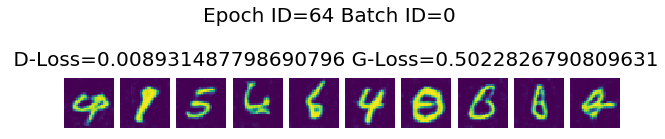

Epoch ID=64 Batch ID=200 

 D-Loss=0.007846126332879066 G-Loss=0.5235300064086914


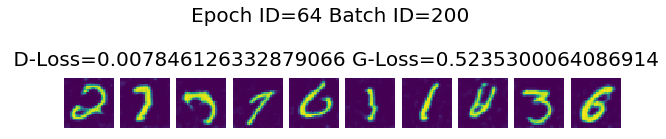

Epoch ID=65 Batch ID=0 

 D-Loss=0.0063721416518092155 G-Loss=0.526885986328125


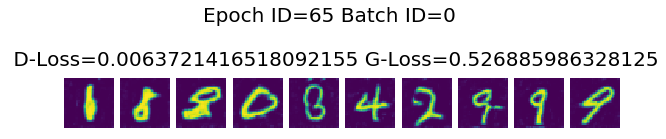

Epoch ID=65 Batch ID=200 

 D-Loss=0.01565375179052353 G-Loss=0.41385409235954285


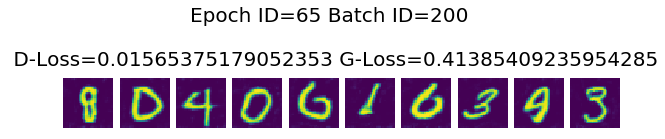

Epoch ID=66 Batch ID=0 

 D-Loss=0.012989304959774017 G-Loss=0.4242229461669922


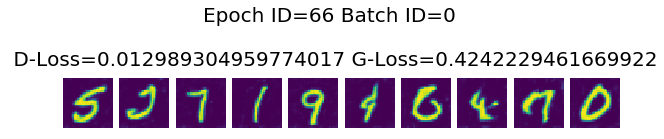

Epoch ID=66 Batch ID=200 

 D-Loss=0.007758762687444687 G-Loss=0.5469778776168823


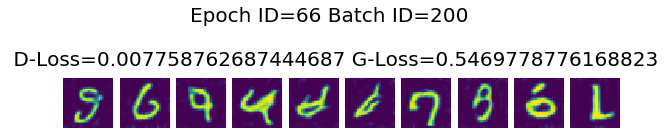

Epoch ID=67 Batch ID=0 

 D-Loss=0.0771908089518547 G-Loss=0.29851001501083374


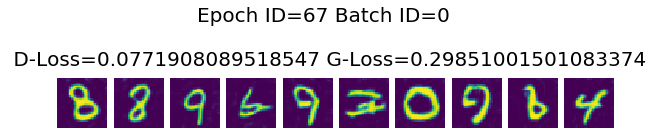

Epoch ID=67 Batch ID=200 

 D-Loss=0.13029661774635315 G-Loss=0.19846098124980927


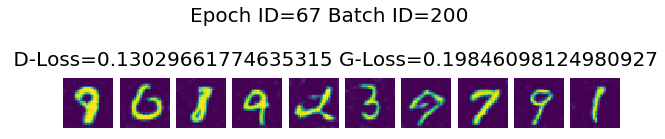

Epoch ID=68 Batch ID=0 

 D-Loss=0.01154412142932415 G-Loss=0.4258694350719452


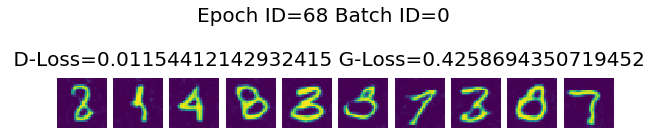

Epoch ID=68 Batch ID=200 

 D-Loss=0.006425852421671152 G-Loss=0.5101633071899414


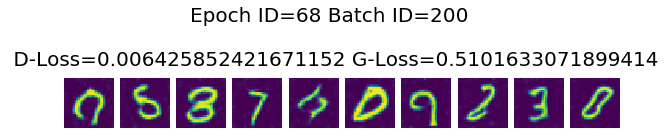

Epoch ID=69 Batch ID=0 

 D-Loss=0.03473221883177757 G-Loss=0.3856547474861145


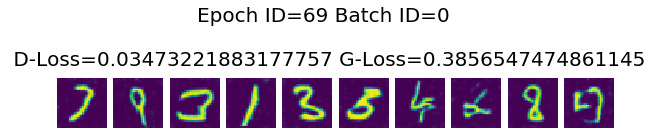

Epoch ID=69 Batch ID=200 

 D-Loss=0.007608711253851652 G-Loss=0.473611980676651


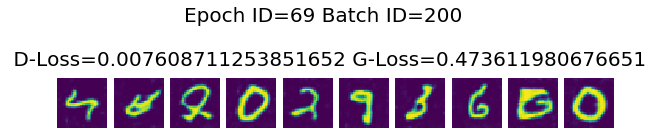

Epoch ID=70 Batch ID=0 

 D-Loss=0.1238086074590683 G-Loss=0.48085257411003113


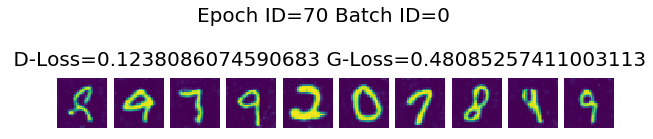

Epoch ID=70 Batch ID=200 

 D-Loss=0.01096801832318306 G-Loss=0.42398083209991455


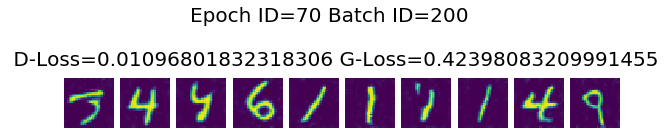

Epoch ID=71 Batch ID=0 

 D-Loss=0.005917430855333805 G-Loss=0.5614656209945679


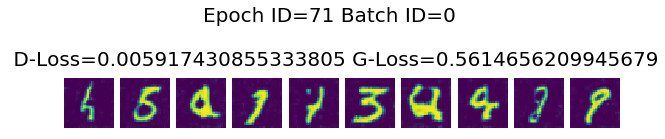

Epoch ID=71 Batch ID=200 

 D-Loss=0.011774295940995216 G-Loss=0.4170302748680115


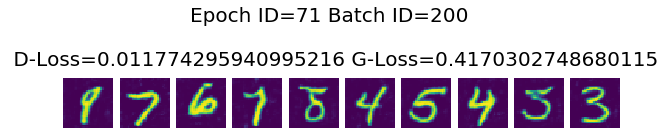

Epoch ID=72 Batch ID=0 

 D-Loss=0.027708636596798897 G-Loss=0.38781529664993286


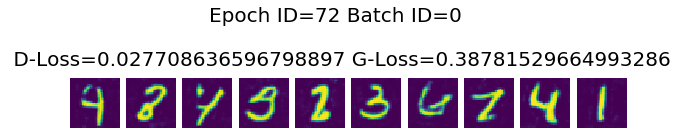

Epoch ID=72 Batch ID=200 

 D-Loss=0.023786641657352448 G-Loss=0.5954102277755737


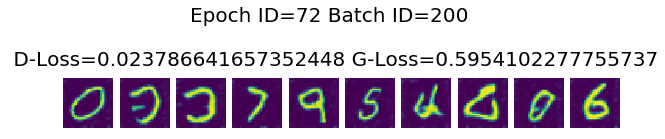

Epoch ID=73 Batch ID=0 

 D-Loss=0.008372233249247074 G-Loss=0.4479081928730011


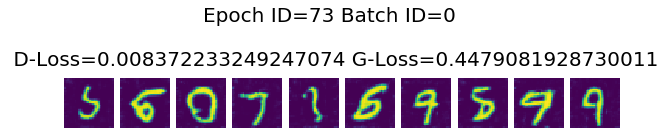

Epoch ID=73 Batch ID=200 

 D-Loss=0.013842122629284859 G-Loss=0.5563865900039673


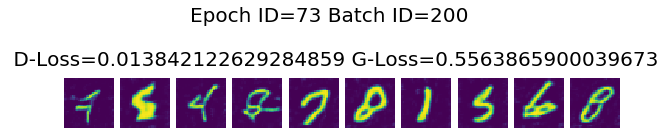

Epoch ID=74 Batch ID=0 

 D-Loss=0.013145255856215954 G-Loss=0.5482329726219177


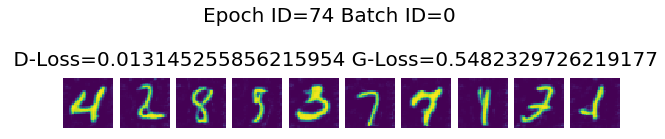

Epoch ID=74 Batch ID=200 

 D-Loss=0.00926220417022705 G-Loss=0.5574415922164917


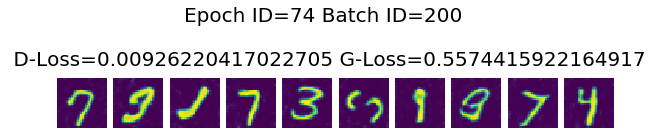

Epoch ID=75 Batch ID=0 

 D-Loss=0.009603610262274742 G-Loss=0.4005301892757416


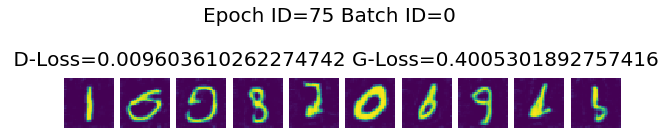

Epoch ID=75 Batch ID=200 

 D-Loss=0.005898855626583099 G-Loss=0.4715716242790222


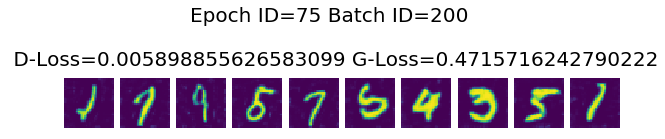

Epoch ID=76 Batch ID=0 

 D-Loss=0.21557419002056122 G-Loss=0.39369964599609375


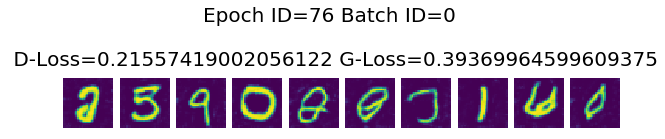

Epoch ID=76 Batch ID=200 

 D-Loss=0.007602950092405081 G-Loss=0.5532082319259644


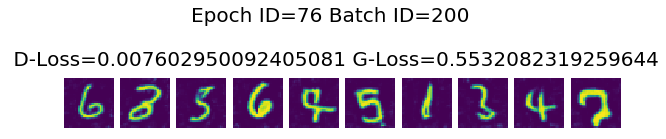

Epoch ID=77 Batch ID=0 

 D-Loss=0.1092258170247078 G-Loss=0.45359522104263306


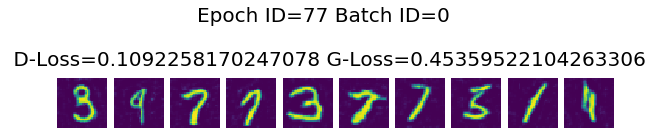

Epoch ID=77 Batch ID=200 

 D-Loss=0.009401237592101097 G-Loss=0.49932122230529785


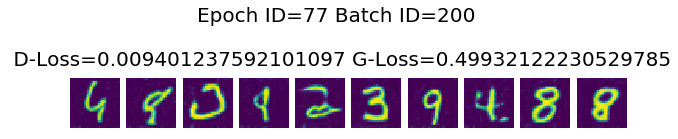

Epoch ID=78 Batch ID=0 

 D-Loss=0.010312078520655632 G-Loss=0.46986013650894165


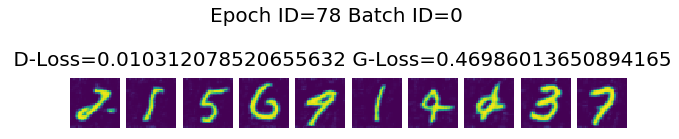

Epoch ID=78 Batch ID=200 

 D-Loss=0.010720296762883663 G-Loss=0.5455833673477173


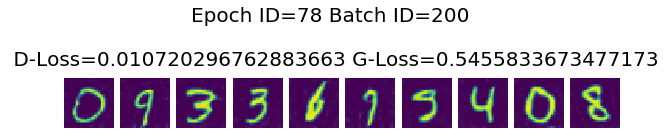

Epoch ID=79 Batch ID=0 

 D-Loss=0.01427130214869976 G-Loss=0.4036540985107422


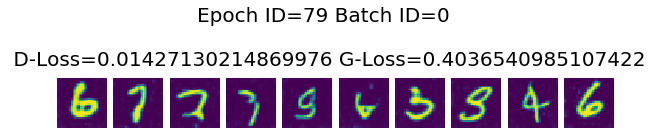

Epoch ID=79 Batch ID=200 

 D-Loss=0.005651852115988731 G-Loss=0.5055004954338074


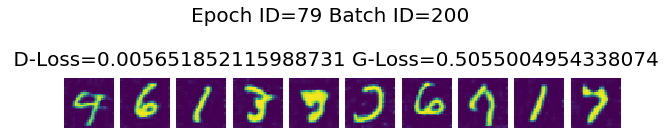

Epoch ID=80 Batch ID=0 

 D-Loss=0.006604163907468319 G-Loss=0.4804970622062683


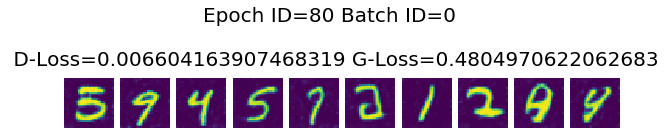

Epoch ID=80 Batch ID=200 

 D-Loss=0.028488360345363617 G-Loss=0.5543793439865112


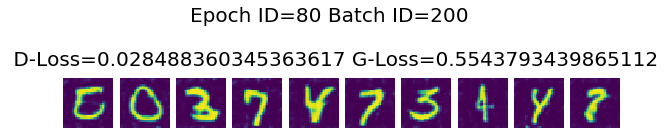

Epoch ID=81 Batch ID=0 

 D-Loss=0.019863558933138847 G-Loss=0.6208798289299011


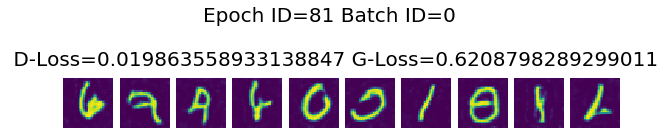

Epoch ID=81 Batch ID=200 

 D-Loss=0.006665701046586037 G-Loss=0.5105370283126831


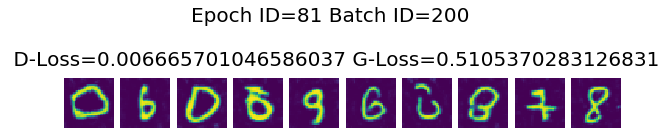

Epoch ID=82 Batch ID=0 

 D-Loss=0.0076598189771175385 G-Loss=0.4946480393409729


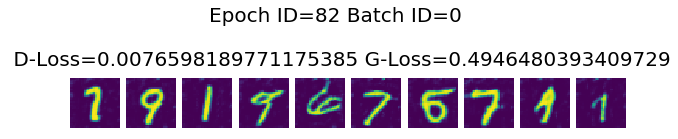

Epoch ID=82 Batch ID=200 

 D-Loss=0.011170824058353901 G-Loss=0.5721086263656616


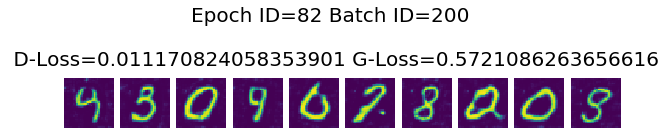

Epoch ID=83 Batch ID=0 

 D-Loss=0.007454773411154747 G-Loss=0.41398823261260986


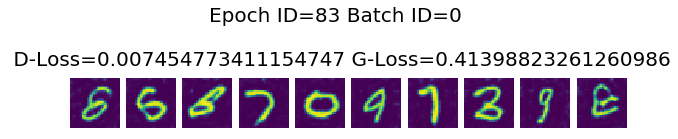

Epoch ID=83 Batch ID=200 

 D-Loss=0.00494527630507946 G-Loss=0.5196314454078674


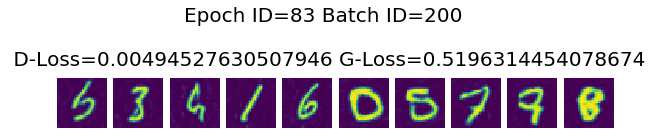

Epoch ID=84 Batch ID=0 

 D-Loss=0.012756227515637875 G-Loss=0.5486763715744019


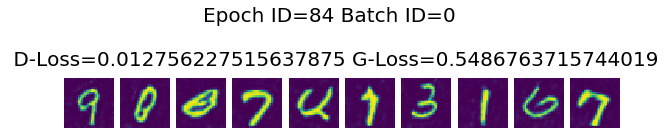

Epoch ID=84 Batch ID=200 

 D-Loss=0.022273238748311996 G-Loss=0.5411897897720337


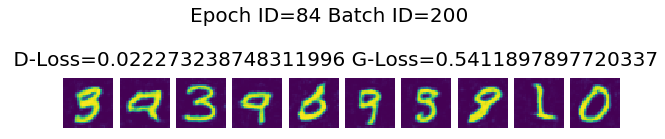

Epoch ID=85 Batch ID=0 

 D-Loss=0.011252586729824543 G-Loss=0.5125386118888855


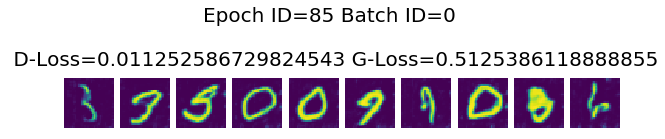

Epoch ID=85 Batch ID=200 

 D-Loss=0.05227791145443916 G-Loss=0.607224702835083


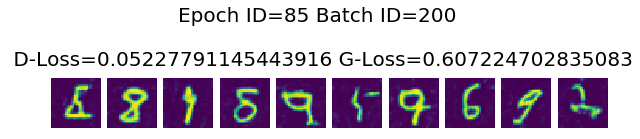

Epoch ID=86 Batch ID=0 

 D-Loss=0.009166798554360867 G-Loss=0.50929194688797


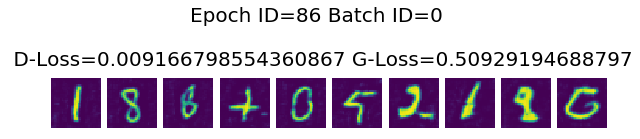

Epoch ID=86 Batch ID=200 

 D-Loss=0.005937656387686729 G-Loss=0.4788573980331421


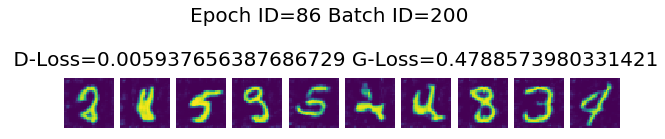

Epoch ID=87 Batch ID=0 

 D-Loss=0.06022780388593674 G-Loss=0.404261976480484


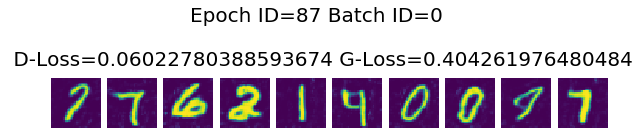

Epoch ID=87 Batch ID=200 

 D-Loss=0.010493636131286621 G-Loss=0.5392003059387207


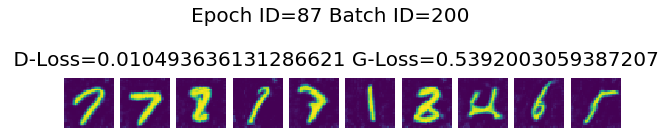

Epoch ID=88 Batch ID=0 

 D-Loss=0.031628064811229706 G-Loss=0.4006202220916748


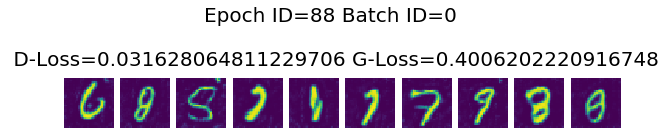

Epoch ID=88 Batch ID=200 

 D-Loss=0.013105817139148712 G-Loss=0.5251455307006836


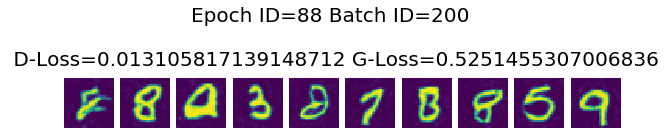

Epoch ID=89 Batch ID=0 

 D-Loss=0.018097255378961563 G-Loss=0.48234593868255615


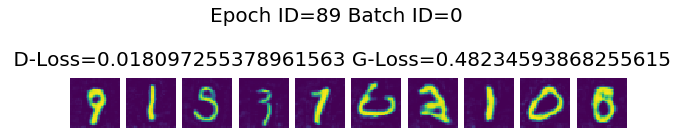

Epoch ID=89 Batch ID=200 

 D-Loss=0.009589442983269691 G-Loss=0.47861728072166443


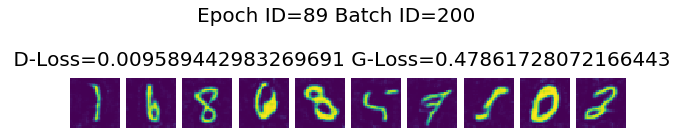

Epoch ID=90 Batch ID=0 

 D-Loss=0.007263148203492165 G-Loss=0.5578843951225281


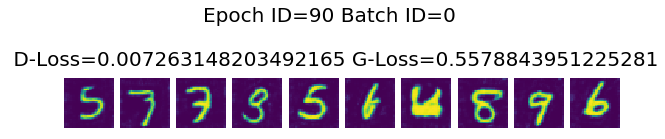

Epoch ID=90 Batch ID=200 

 D-Loss=0.010009286925196648 G-Loss=0.5326584577560425


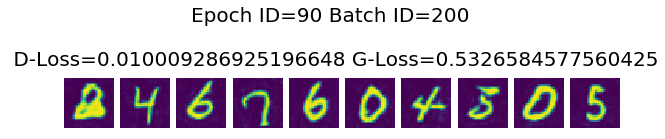

Epoch ID=91 Batch ID=0 

 D-Loss=0.008102464489638805 G-Loss=0.48788243532180786


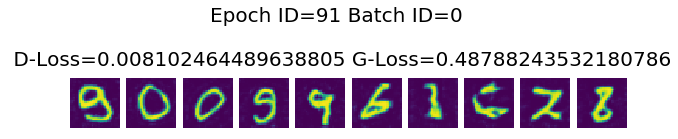

Epoch ID=91 Batch ID=200 

 D-Loss=0.005878766067326069 G-Loss=0.47081199288368225


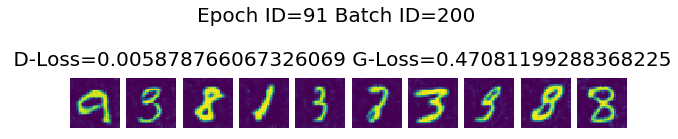

Epoch ID=92 Batch ID=0 

 D-Loss=0.009851999580860138 G-Loss=0.5911814570426941


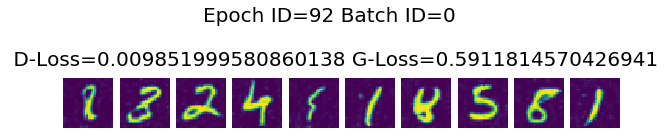

Epoch ID=92 Batch ID=200 

 D-Loss=0.011832792311906815 G-Loss=0.5104879140853882


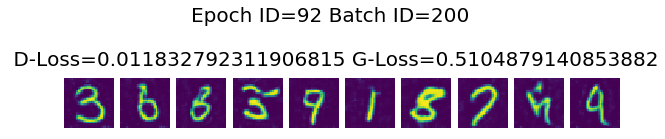

Epoch ID=93 Batch ID=0 

 D-Loss=0.014141878113150597 G-Loss=0.4497504234313965


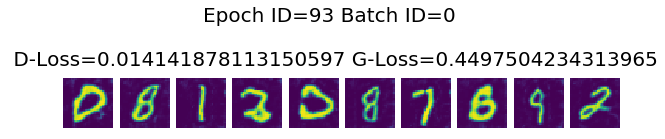

Epoch ID=93 Batch ID=200 

 D-Loss=0.008552350103855133 G-Loss=0.49985092878341675


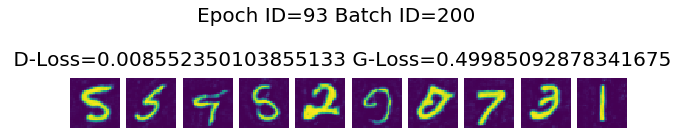

Epoch ID=94 Batch ID=0 

 D-Loss=0.010632784105837345 G-Loss=0.5436207056045532


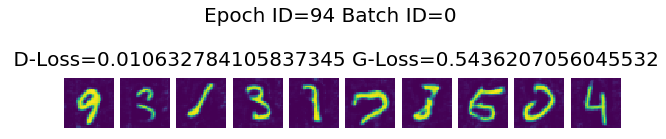

Epoch ID=94 Batch ID=200 

 D-Loss=0.015277950093150139 G-Loss=0.4581977128982544


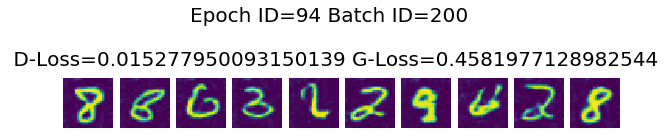

Epoch ID=95 Batch ID=0 

 D-Loss=0.006789944134652615 G-Loss=0.5109097957611084


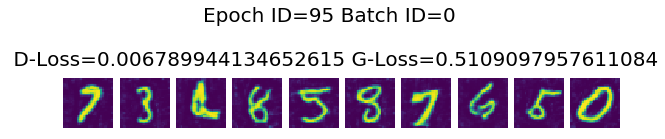

Epoch ID=95 Batch ID=200 

 D-Loss=0.01030987873673439 G-Loss=0.4585127830505371


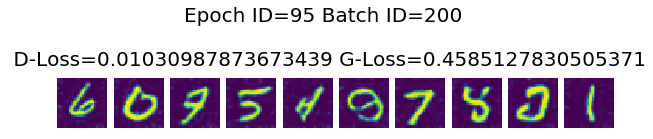

Epoch ID=96 Batch ID=0 

 D-Loss=0.020665869116783142 G-Loss=0.5683664083480835


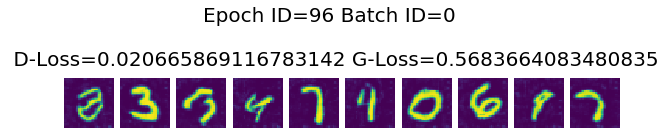

Epoch ID=96 Batch ID=200 

 D-Loss=0.0052238767966628075 G-Loss=0.47285908460617065


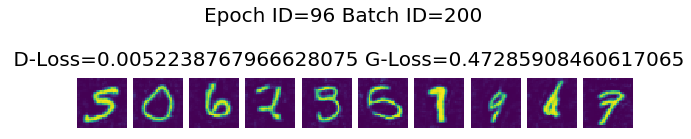

Epoch ID=97 Batch ID=0 

 D-Loss=0.008773834444582462 G-Loss=0.5102346539497375


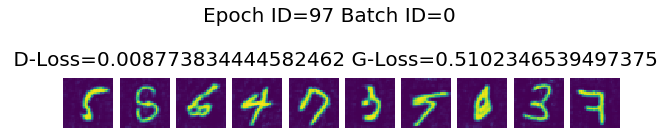

Epoch ID=97 Batch ID=200 

 D-Loss=0.004522057715803385 G-Loss=0.4133334457874298


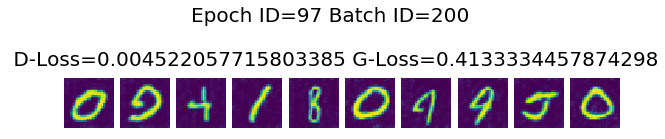

Epoch ID=98 Batch ID=0 

 D-Loss=0.004490025341510773 G-Loss=0.4740501046180725


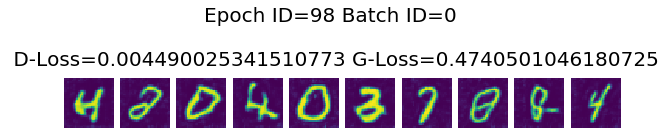

Epoch ID=98 Batch ID=200 

 D-Loss=0.010032260790467262 G-Loss=0.4623270332813263


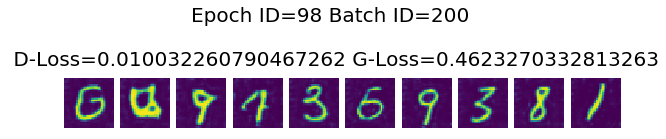

Epoch ID=99 Batch ID=0 

 D-Loss=0.006423374637961388 G-Loss=0.50047367811203


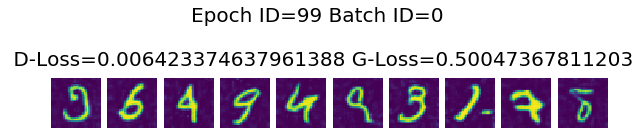

Epoch ID=99 Batch ID=200 

 D-Loss=0.007795094046741724 G-Loss=0.428654283285141


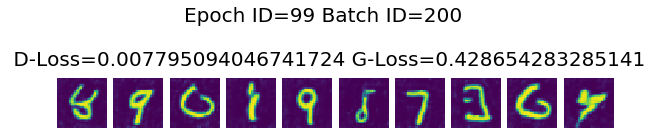

Epoch ID=100 Batch ID=0 

 D-Loss=0.05036166310310364 G-Loss=0.4155038297176361


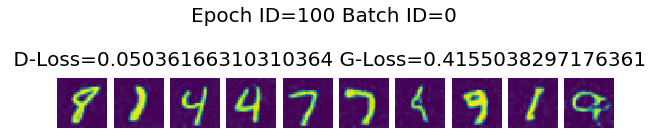

Epoch ID=100 Batch ID=200 

 D-Loss=0.010250557214021683 G-Loss=0.5495871305465698


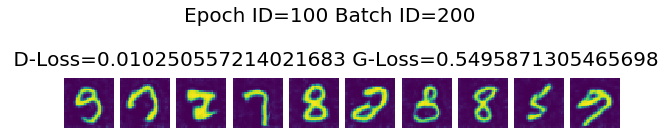

In [20]:
losses = [[], []]
#plt.ion()
now = 0
epochs = 100
for pass_id in range(epochs):
    for batch_id, (data, target) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        optimizerD.clear_grad()
        real_img = data
        bs_size = real_img.shape[0]
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype='float32') # set 1
        real_out = netD(real_img)
        errD_real = loss(real_out, label)
        errD_real.backward()

        noise = paddle.randn([bs_size, 100, 1, 1], 'float32')
        fake_img = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), fake_label, dtype='float32')  # set 0
        fake_out = netD(fake_img.detach())
        errD_fake = loss(fake_out, label)
        errD_fake.backward()
        optimizerD.step()
        optimizerD.clear_grad()

        errD = 0.5 * errD_real + 0.5 * errD_fake
        losses[0].append(errD.numpy()[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.clear_grad()
        noise = paddle.randn([bs_size, 100, 1, 1],'float32')
        fake = netG(noise)
        label = paddle.full((bs_size, 1, 1, 1), real_label, dtype=np.float32) # set 1
        output = netD(fake)
        errG = 0.5 * loss(output,label)
        errG.backward()
        optimizerG.step()
        optimizerG.clear_grad()

        losses[1].append(errG.numpy()[0])


        ############################
        # visualize
        ###########################
        if batch_id % 200 == 0:
            generated_image = netG(noise).numpy()  # N C H W
            imgs = []
            plt.figure(figsize=(10, 10))
            try:
                for i in range(10):
                    image = generated_image[i].transpose()  # H W C
                    # image = np.where(image > 0, image, 0)   # ?生成器用了tanh又截取 而不用sigmoid 不理解为什么
                    image = image.transpose((1, 0, 2)) # H W C -> W H C
                    plt.subplot(10, 10, i + 1)
                    
                    plt.imshow(image[...,0], vmin=-1, vmax=1)
                    plt.axis('off')
                    plt.xticks([])
                    plt.yticks([])
                    plt.subplots_adjust(wspace=0.1, hspace=0.1)
                msg = 'Epoch ID={0} Batch ID={1} \n\n D-Loss={2} G-Loss={3}'.format(pass_id+1, batch_id, errD.numpy()[0], errG.numpy()[0])
                print(msg)
                plt.suptitle(msg, fontsize=20)
                plt.draw()
                plt.savefig('{}/{:04d}_{:04d}.png'.format('work', pass_id, batch_id), bbox_inches='tight')
                plt.pause(0.01)
            except IOError:
                print(IOError)
    paddle.save(netG.state_dict(), "work/generator.params")

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 